## Importing Libraries

In [4]:
from importlib import reload
import pandas as pd
import model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
reload(ms)

<module 'model_selection' from 'e:\\Ames-Housing-Price-Predictor\\notebooks\\model_selection.py'>

## Load dataset

In [2]:
df = pd.read_parquet('../data/processed/06_feature_selection.parquet')

In [3]:
x = df.drop(columns=['saleprice'])
y = df['saleprice']
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42,
)

## Model Training

Based on the results from `07_model_selection.ipynb`, the best-performing model was the `CatBoostRegressor`. Therefore, in this notebook, I will focus on tuning the `CatBoost` and `Linear Regression` models to further improve its performance.

In [5]:
models = {
    'CatBoost': CatBoostRegressor(task_type='GPU', devices='0', verbose=0),
    'Linear Regression': LinearRegression()
}

In [ ]:
from scipy.stats import loguniform, randint

param_dist = {
    'CatBoost': {
        'iterations':   randint(100, 300),
        'learning_rate': loguniform(1e-3, 0.2),
        'depth':        randint(4, 8),
        'l2_leaf_reg':  [1, 3, 5, 10]
    },
    'Linear Regression': {
        'fit_intercept': [True, False],
    }
}

In [9]:
models_pro = ms.regression_hyperparameter_tuning(x_train, y_train, models, param_dist, cv=2, n_iter = 50)

✅ Tuning hyperparameter for CatBoost...
Best hyperparameters for CatBoost: {'depth': 5, 'iterations': 268, 'l2_leaf_reg': 5, 'learning_rate': np.float64(0.08125418703579033)}

✅ Tuning hyperparameter for Linear Regression...
Best hyperparameters for Linear Regression: {'fit_intercept': True}



e:\Ames-Housing-Price-Predictor\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [10]:
regression_metrics, predictions_dict, importances_dict = ms.model_predict(models_pro, x_train, x_test, y_train, y_test)


✅ Testing CatBoost...
MAE: 13701.615929605116 | MSE: 447800081.83577764 | RMSE: 21161.287338812297 | R²: 0.9441475017430826 | RMSLE: 0.10210928261517699 | MAPE: 0.0752427915452894
--------------------------------------------------

✅ Testing Linear Regression...
MAE: 19374.488352653305 | MSE: 967021209.8113599 | RMSE: 31096.964639838403 | R²: 0.8793869125392466 | RMSLE: 0.14789121336336486 | MAPE: 0.10639078687890885
--------------------------------------------------


## Model Evaluation

In [11]:
regression_metrics

,Model,MAE,MSE,RMSE,R²,RMSLE,MAPE
0,CatBoost,13701.615930,4.478001e+08,21161.287339,0.944148,0.102109,0.075243
1,Linear Regression,19374.488353,9.670212e+08,31096.964640,0.879387,0.147891,0.106391


### Residuals Plot

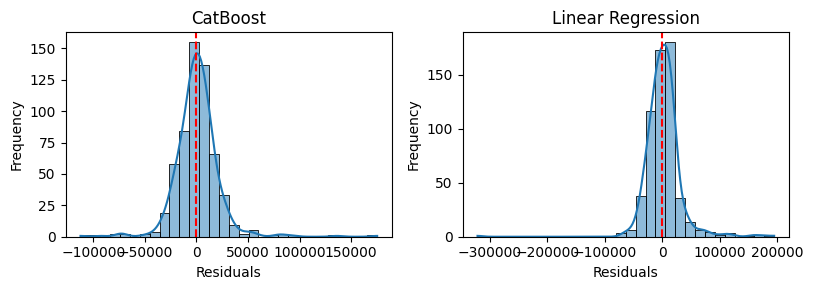

In [12]:
reload(ms)
ms.plot_residuals(y_test, predictions_dict, n_cols=5)

### Scatter Plot

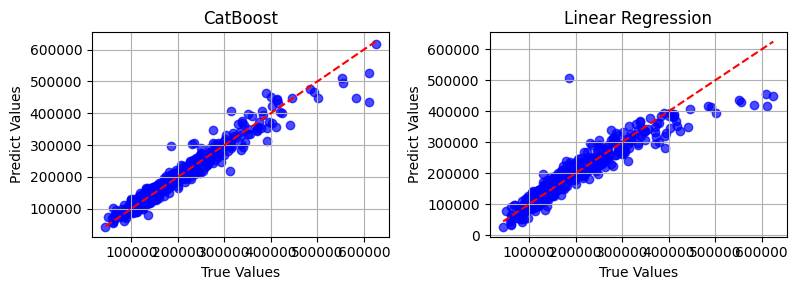

In [13]:
reload(ms)
ms.scatter_plot(y_test, predictions_dict, n_cols=5)

### Feature Importance

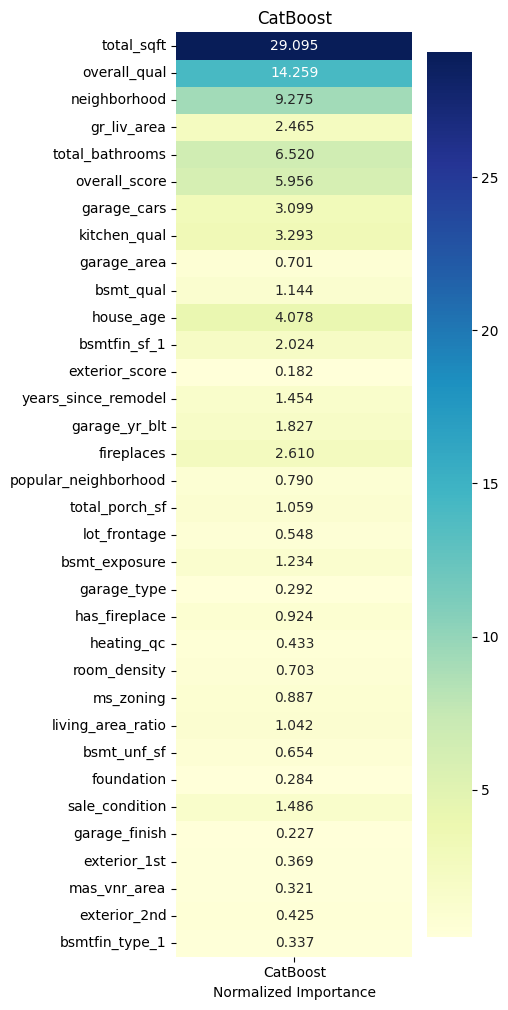

In [14]:
reload(ms)
ms.plot_feature_importances(x.columns,importances_dict)

### Learning Curve

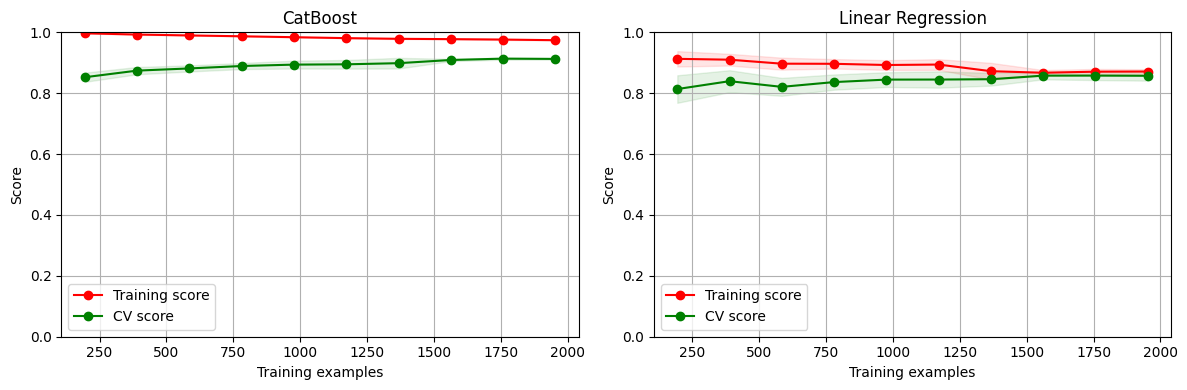

In [15]:
reload(ms)
learning_curve_summary = ms.learning_curves_regression(models_pro, x, y, cv=3, scoring='r2', cols=2)

### Learning Curve Summary

In [16]:
learning_curve_summary

,Model,Train score,CV score,Gap,Best n_samples
0,CatBoost,0.974158,0.912683,0.061475,1757
1,Linear Regression,0.871213,0.857255,0.013958,1757


### Best Model

In [22]:
models_pro['CatBoost'].save_model('../models/catboost_model_pro.cbm')